<a href="https://colab.research.google.com/github/mashaan14/YouTube-channel/blob/main/notebooks/2024_02_13_SSC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sparse Subspace Clustering

## YouTube:
I explained this notebook in a [YouTube video](https://youtu.be/xUmO_S7lLG8).

## Acknowledgment:
* Original Matlab code  [Vision Lab-Johns Hopkins University](http://vision.jhu.edu/code/).
* SSC implementation  [Clustering-Codes](https://github.com/sohanghosh29/Clustering-Codes/tree/master).

## References:
```bibtex
@misc{elhamifar2013sparse,
 title        ={Sparse Subspace Clustering: Algorithm, Theory, and Applications},
 author       ={Ehsan Elhamifar and Rene Vidal},
 year         ={2013},
 eprint       ={1203.1005},
 archivePrefix ={arXiv},
 primaryClass ={cs.CV}
}
```
```bibtex
@inproceedings{NEURIPS2019_a0d3973a,
 author     = {Matsushima, Shin and Brbic, Maria},
 booktitle  = {Advances in Neural Information Processing Systems},
 title      = {Selective Sampling-based Scalable Sparse Subspace Clustering},
 volume     = {32},
 year       = {2019}
}
```

In [ ]:
# Standard libraries
import numpy as np
from scipy import sparse
import scipy.io as sp
import seaborn as sns
import pandas as pd

# Plotting libraries
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib import cm
from IPython.display import Javascript  # Restrict height of output cell.

# scikit-learn
from sklearn.datasets import (make_blobs, make_circles)
from sklearn.utils import shuffle
from sklearn.cluster import SpectralClustering
from sklearn.manifold import TSNE
from sklearn import datasets
from sklearn.decomposition import PCA

# CVXPY for convex optimization
import cvxpy as cvx
from cvxpy.atoms.elementwise.power import power

In [ ]:
random_seed = 42
plt.style.use('dark_background')
plot_colors = cm.tab10.colors

## Prepare a synthetic dataset

In [ ]:
def rotate(xy, theta):
    """
    Returns a rotated set of points.
    """
    s = np.sin(theta * np.pi / 180)
    c = np.cos(theta * np.pi / 180)
    center_of_rotation = np.mean(xy, axis=0)

    xyr = np.zeros((xy.shape[0], xy.shape[1]))
    xyr[:, 0] = (c * (xy[:, 0]-center_of_rotation[0])) - (s * (xy[:, 1]-center_of_rotation[1])) + center_of_rotation[0]
    xyr[:, 1] = (s * (xy[:, 0]-center_of_rotation[0])) + (c * (xy[:, 1]-center_of_rotation[1])) + center_of_rotation[1]

    return xyr

In [ ]:
def make_lines(angle):
  """
  Returns three lines with the last two rotated by (90-angle) and (90+angle).
  """
  num_of_points = 200
  noise_factor = 0.1
  rng = np.random.default_rng(seed=random_seed)

  x = np.linspace(0, 6, num_of_points) + rng.normal(0, 1, num_of_points) * noise_factor
  zeros = np.zeros_like(x) + rng.normal(0, 1, num_of_points) * noise_factor

  X1 = np.vstack((x,zeros)).T
  X2 = np.vstack((x+0.0001,zeros)).T
  X3 = rotate(X1, 90 - angle)
  X4 = rotate(X1, 90 + angle)

  X = np.concatenate((X1, X2, X3, X4), axis=0)
  y = np.concatenate((np.zeros((X1.shape[0])),
                      np.zeros((X2.shape[0])),
                      np.zeros((X3.shape[0]))+1,
                      np.zeros((X4.shape[0]))+2)).astype(int)

  X, y = shuffle(X, y, random_state=random_seed)
  y_colors = np.array(plot_colors)[y]
  dataset = {'X': X, 'y': y, 'y_colors': y_colors}

  return dataset

In [ ]:
def make_rings():
  """
  Returns three rings dataset.
  """

  X, y = make_blobs(n_samples=200, n_features=2, centers=1, cluster_std=0.15, random_state=random_seed)
  # center at the origin
  X = X - np.mean(X, axis=0)

  X1, y1 = make_circles(n_samples=[600, 200], noise=0.04, factor=0.5, random_state=random_seed)
  # add 1 to (make_circles) labels to account for (make_blobs) label
  y1 = y1 + 1
  # increase the radius
  X1 = X1*3

  X = np.concatenate((X, X1), axis=0)
  y = np.concatenate((y, y1), axis=0)

  X, y = shuffle(X, y, random_state=random_seed)
  y_colors = np.array(plot_colors)[y]
  dataset = {'X': X, 'y': y, 'y_colors': y_colors}

  return dataset

In [ ]:
dataset_list = []
dataset_list.append(make_lines(30))
dataset_list.append(make_lines(45))
dataset_list.append(make_rings())

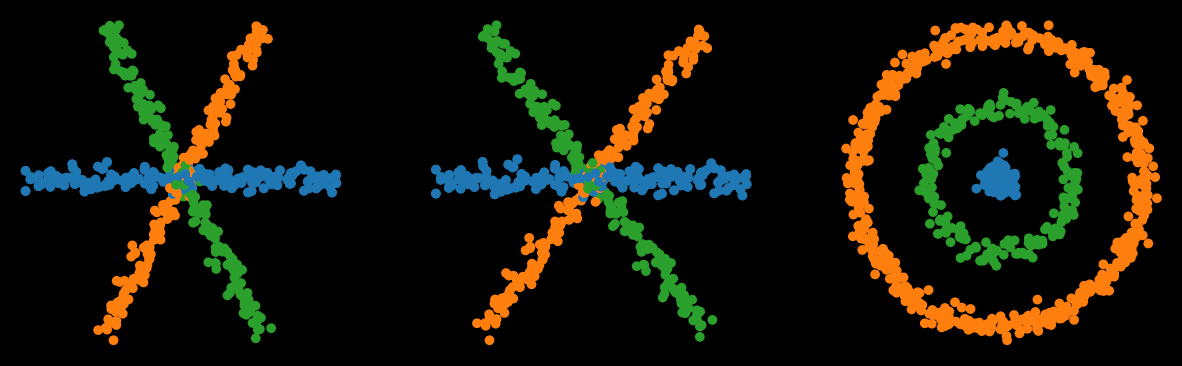

In [ ]:
fig, axs = plt.subplots(1, len(dataset_list), figsize=(15, 4.5))

for i, d in enumerate(dataset_list):
  axs[i].axis('off')
  axs[i].scatter(d['X'][:, 0], d['X'][:, 1], color=d['y_colors'])

plt.show()

## SSC algorithm

In [ ]:
def find_sparse_sol(Y,i,N,D):
  if i == 0:
    # include all points after the first point
    Ybari = Y[:,1:N]
  if i == N-1:
    # include all points except the last one
    Ybari = Y[:,0:N-1]
  if i!=0 and i!=N-1:
    # include all the points before and after the point i
    Ybari = np.concatenate((Y[:,0:i],Y[:,i+1:N]),axis=1)

  # the point i
  yi = Y[:,i].reshape(D,1)

  # this ci will contain the solution of the l1 optimisation problem:
  # min (||yi - Ybari*ci||F)^2 + lambda*||ci||1   st. sum(ci) = 1
  ci = cvx.Variable(shape=(N-1,1))
  constraint = [cvx.sum(ci)==1]
  # a penalty in the 2-norm of the error is added to the l1 norm to account for noisy data
  obj = cvx.Minimize(power(cvx.norm(yi-Ybari@ci,2),2) + 0.082*cvx.norm(ci,1)) #lambda = 0.082
  prob = cvx.Problem(obj, constraint)
  prob.solve()
  return ci.value

## SSC adjacency

In [ ]:
def make_adjacency(dataset):
  """
  Returns SSC adjacency
  """
  X = dataset['X']
  y = dataset['y']
  y_colors = dataset['y_colors']

  N = X.shape[0]
  D = X.shape[1]
  C = np.concatenate((np.zeros((1,1)),find_sparse_sol(X.T,0,N,D)),axis=0)

  for i in range(1,N):
    ci = find_sparse_sol(X.T,i,N,D)
    zero_element = np.zeros((1,1))
    cif = np.concatenate((ci[0:i,:],zero_element,ci[i:N,:]),axis=0)
    C = np.concatenate((C,cif),axis=1)

  # keep only one maximum value per row
  max_idx = 1   # number of max values to return
  mask = np.argpartition(-C, max_idx-1, axis=0) # returns an array where the index zero corresponds the the maximum
  mask = mask > max_idx-1 # masked values that are not max values
  C[mask] = 0 # set non max values to zero

  # force the adjacency matrix to be symmetric
  W = np.add(np.absolute(C), np.absolute(C.T))

  d = {'X': X, 'y': y, 'y_colors': y_colors, 'W': W}

  return d

In [ ]:
dataset_list_graph = []
for _ , d in enumerate(dataset_list):
  dataset_list_graph.append(make_adjacency(d))

/usr/local/lib/python3.10/dist-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


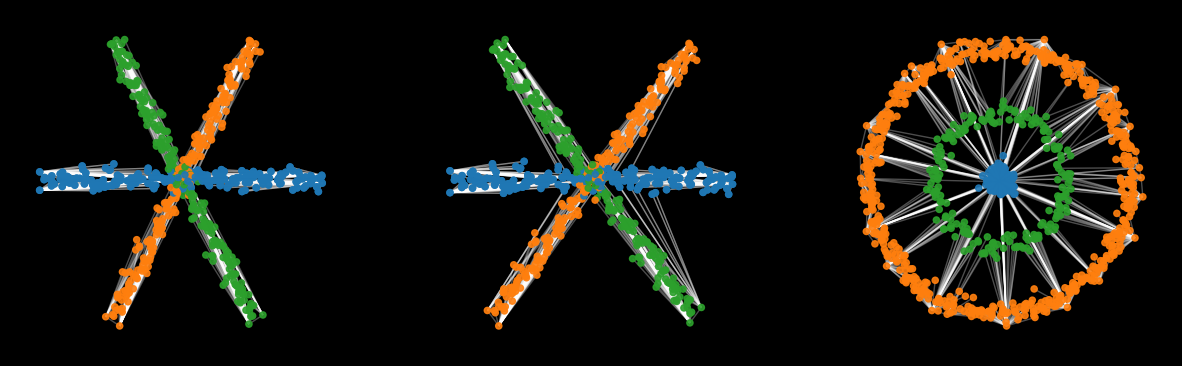

In [ ]:
fig, axs = plt.subplots(1, len(dataset_list_graph), figsize=(15, 4.5))

for i, d in enumerate(dataset_list_graph):
  axs[i].axis('off')

  G = nx.from_numpy_array(d['W'])

  nx.draw_networkx_nodes(G, pos=d['X'], node_size=20, node_color=d['y_colors'], alpha=0.9, ax=axs[i])
  nx.draw_networkx_edges(G, pos=d['X'], edge_color="white", alpha=0.3, ax=axs[i])

plt.show()

## Spectral Clustering

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


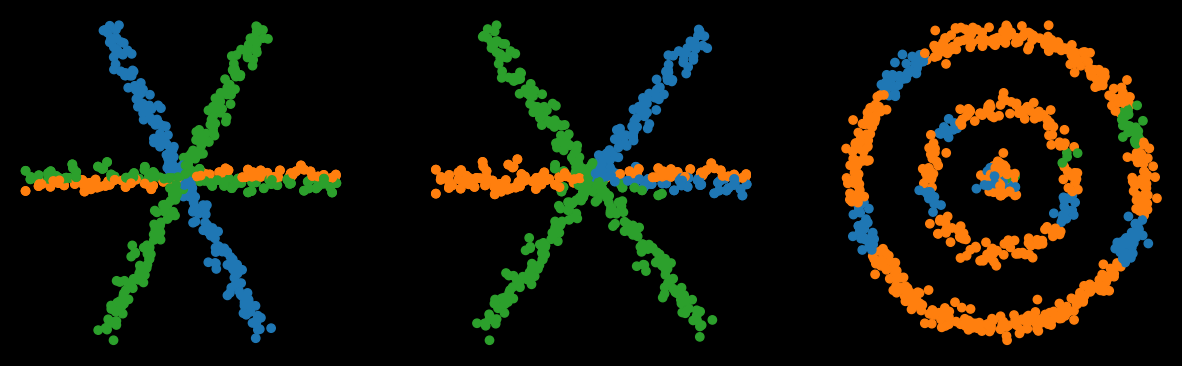

In [ ]:
fig, axs = plt.subplots(1, len(dataset_list), figsize=(15, 4.5))

for i, d in enumerate(dataset_list_graph):

  clustering = SpectralClustering(n_clusters=3, n_components=1, affinity='precomputed', assign_labels='kmeans', random_state=random_seed).fit(d['W'])
  clustering_colors = np.array(plot_colors)[clustering.labels_]
  axs[i].axis('off')
  axs[i].scatter(d['X'][:, 0], d['X'][:, 1], color=clustering_colors)

plt.show()

## Iris Dataset

In [ ]:
iris = datasets.load_iris()

X = iris.data
X = PCA(n_components=2).fit_transform(X)
y = iris.target
y_colors = np.array(plot_colors)[y]
iris_dataset = {'X': X, 'y': y, 'y_colors': y_colors}

In [ ]:
iris_dataset = make_adjacency(iris_dataset)

In [ ]:
clustering = SpectralClustering(n_clusters=3, affinity='precomputed', assign_labels='kmeans', random_state=random_seed).fit(iris_dataset['W'])
clustering_colors = np.array(plot_colors)[clustering.labels_]

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


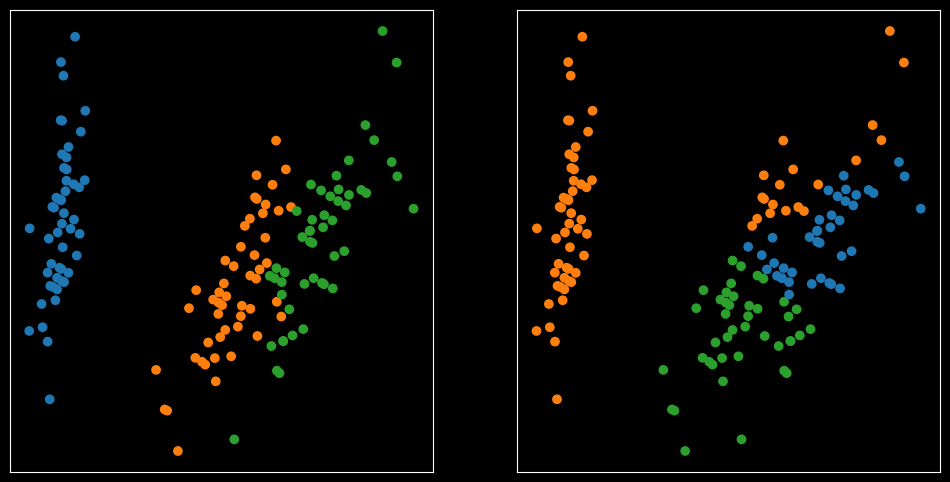

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].scatter(X[:, 0], X[:, 1], color=y_colors)
axs[0].tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False,
          labelbottom=False,labeltop=False,labelleft=False,labelright=False);
axs[0].set(xlabel=None, ylabel=None)

axs[1].scatter(X[:, 0], X[:, 1], color=clustering_colors)
axs[1].tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False,
          labelbottom=False,labeltop=False,labelleft=False,labelright=False);
axs[1].set(xlabel=None, ylabel=None)

plt.show()